# More on feature engineering

In this notebook, we return to the topic of feature engineering from the previous lecture, but look at more complex examples of feature engineering. Many of these examples combine **domain knowledge** with machine learning. What this means is that the kind of data we have lends itself to certain types of features engineering that may not apply to other types of data. The best way to learn about this kind of feature engineering is by looking at examples: feature engineering with text data, with time series data, with image or video data, with sound data, and so on. So as our example, we will look at feature engineering for text data. To make things more interesting, we finish this notebook by training a supervised learning algorithm on the resulting data. This last part will warm us up for next week's lecture!

Let's look at an example dealing with text data. Raw text data is an unstructured and ubiquitous type of data. Most of the world’s data is unstructured. Volumes of unstructured data, including text, are growing much faster than structured data. There are many industry estimates for the fraction of all data which is unstructured. How much text data are we talking about here? In a few years time, Twitter will have [more text data recorded](http://www.internetlivestats.com/twitter-statistics/) than all that has been written in print in the history of mankind.

Given the ubiquity and volume of text data, it is not surprising that numerous powerful applications which exploit text analytics are appearing. A few of these applications are listed below.

- Intelligent applications
  - Assistants
  - Chat bots
- Classification
  - Sentiment analysis
  - SPAM detection
- Speech recognition
- Search
- Information retrieval
- Legal discovery

In this tutorial we investigate two areas of text analytics:

- Pre-processing text data for analysis
- Classification of text and sentiment analysis

In [59]:
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cProfile
import argparse
import pprint
import seaborn as sns

from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [60]:
nltk.download('wordnet')
nltk.download('stopwords')

# If you get an SSL-certificate error, and you are on a MAC then you may have to navigate to: application/python3/ and
# run/double-click on the command 'install certificates'.  Then try this again.

from nltk.stem.wordnet import WordNetLemmatizer

###Sometimes if you have email addresses or numbers or letters that will not be relevant, should you keep them? remove them? etc...
###

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The very first step to prepare text is to clean it.  We clean and normalize the text by performing various operations on the text. Some examples are as follows:

- Make the text lowercase.
- Remove symbols or punctuation.
- Remove numbers. May also replace all numbers with a numeric tag, for example `<NUM>` or similar. We may also consider replacing all dates with `<DATE>` or similarly use tags `<URL>`, `<PHONE>`, `<EMAIL>`, etc...
- Strip extra white space. White space has many forms: space, newline, or tab. There are also other rarely used unicode specifications for other white space characters.
- Remove all non-printable unicode characters.
- Replace accent characters.
- Remove 'stop words'. Stop words are generally non-informative words like "the", "as", "a", etc.
- Stem words to similar endings, such as "eats" and "eat".

There are a few reasons to clean your text.  The primary reason is to reduce the potential vocabulary and increase the observations of specific words (or tokens). Depending on the application, the above steps should be considered carefully and only applied when it makes sense. Ask yourself if words like "China" and "china" to be different.

**NOTE**: Be careful dealing with unicode characters. There are many editors and text viewers that only display printable characters but will not remove non-printable characters. Strange unicode characters can end up in data from users blindly copy/pasting text (with invisible unicode) into other text boxes.

### Exercise (8 minutes)

By its very nature, text data comes unstructured and poorly organized for analysis. Typically multiple steps are required to process text into a form suitable for analysis, starting with cleaning it.

Here's a horrible tweet. We're going to clean it and learn about ways to clean text data in the process.

In [61]:
horrible_tweet_text = 'I <3 cleaning data $\ \ $, it’s my \u1072  $\ \ $    fAvoRitE!! 11!!! I enjoy looking for bats in the closet'
print('Unfiltered text: \n{}\n'.format(horrible_tweet_text))

Unfiltered text: 
I <3 cleaning data $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!! I enjoy looking for bats in the closet



Step by step, refine the above text. To avoid overwriting the existing string, you can create a new string from the string so far each time.

- Remove any non-ASCI character. A string `x` is ASCI if `ord(x) < 128`.

In [62]:
text =''.join([x for x in horrible_tweet_text if ord(x) < 128])

- Make all the letters lower case.

In [63]:
text = text.lower()
text

'i <3 cleaning data $\\ \\ $, its my   $\\ \\ $    favorite!! 11!!! i enjoy looking for bats in the closet'

- Remove all punctuation from the text. You can use `string.punctuation` to get a string of all punctuation characters.

In [64]:
punc = string.punctuation
text = ''.join([' ' if ele in punc else ele for ele in text])

print('Removed punctuation text: \n{}\n'.format(text))

Removed punctuation text: 
i  3 cleaning data         its my             favorite   11    i enjoy looking for bats in the closet



- Remove all the numbers from the text. HINT: If you are familiar with **regular expressions** you can use `re.sub` to do this easily.

In [65]:
text = re.sub(r'\d+', '', text)
print('Removed numbers text: \n{}\n'.format(text))

Removed numbers text: 
i   cleaning data         its my             favorite       i enjoy looking for bats in the closet



- Strip the text of any extra whitespace. HINT: The `split` method might help here.

In [66]:
text = ' '.join(text.split())
print('Removed whitespace spaces text: \n{}\n'.format(text))

Removed whitespace spaces text: 
i cleaning data its my favorite i enjoy looking for bats in the closet



- Remove all stop words from the text. We can use `stopwords.words('english')` to get a list of stop words for the English language.

In [67]:
text = ' '.join(['' if ele in stopwords.words('english') else ele for ele in text.split()])

print('updated text: \n{}\n'.format(text))

updated text: 
 cleaning data   favorite  enjoy looking  bats   closet



- Let's now use `WordNetLemmatizer()` to reduce the words to their **stems**. HINT: Use the object's `lemmatize` method.

In [68]:
lmtzr = WordNetLemmatizer()
word_list = text.split(' ')
stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
text = ' '.join(stemmed_words) 
print('updated text: \n{}\n'.format(text))

updated text: 
 cleaning data   favorite  enjoy looking  bat   closet



### End of exercise

Let's now combine the steps outlined in the above exercise and create a function to clean text for use. We will later use this function.

In [70]:
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

print("before: \"{}\"".format(horrible_tweet_text))
print("after : \"{}\"".format(preprocess(horrible_tweet_text, step_list)))

before: "I <3 cleaning data $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!! I enjoy looking for bats in the closet"
after : "cleaning data favorite enjoy looking bat closet"


### Featurizing text data

We the clean data we can begin to ask what is the best way to extract features from the data. There are many more approaches for text analytics and natural language processing (NLP). We only mention a few below. Note that the collection of unique words in the data is called a **corpus**. To avoid having a corpus that's too large, we can trim the corpus by keeping the most frequent $N$ words, making $N$ the size of the corpus. A **document** usually refers to a single data point with raw text, such as a tweet, a review, an invoice, etc. So our documents are made up of "words" that come from the corpus (ignoring any words that are not in the corpus). The question now is how do we represent such a data numerically? Here are two approaches:

- The **bag of words model** is a simple and surprisingly effective model for analysis of text data. The BOW model creates a **sparse vector representation** of each word in the corpus based on the frequency of the words in the document. The order of the words is not considered, nor is the similarity between different words. Despite serious shortcomings, the model can work well in many cases.
- We can usually do much better by using **word embeddings**, which are **dense vector respresentations** for each word in the corpus. Word embeddings are learned by examining the word's **context** (other words around it). Word embeddings are very common in **deep learning** applications of NLP, although the embeddings themselves are learned using a shallow network. If we learn word embeddings from a very large data set once, we can save and re-use these word embeddings to create features for other data sets. In fact, **pre-trained word embeddings** are trained by large companies like Google and made available for use by others. So we can load these embeddings and numerically represent a document using the average of the embeddings of the words in it. Because word embeddings are vectors, such an average would also be a vector that is a dense representation of the document.

As you can see, BOW models seem too simplistic and word embeddings seem too sophisticated for now. So here's another approach that is sort of between the two in terms of difficulty. It is called TF-IDF and it is a clever way to featurize words in documents. Just like a BOW model, we begin by "tokenizing" the data. In BOW we then create a one-hot encoded feature for each token (or word). But in TF-IDF we first extract the relative word frequencies per document (called **term frequencies** or TF), we then multiply the term frequencies by a multiplier we call IDF. This has the effect of dampening the values for terms that appear frequently across documents, giving them less influence when we move on to the machine learning phase. Note that we used the words token, word and term almost interchangeably. Sorry for confusing you! Data scientists don't always agree on terminology. Let's dive in.

### Tokenize text

As a first step in preparing text for analysis of a document is to **tokenize** the text. In general terms, tokenization is the process dividing raw text into words, symbols and other elements, known as **tokens**. A set of tokens from all documents in the data is known as a **corpus**.

As a first step in creating a corpus is reading the data set. This particular data set is comprised of 160,000 tweets. The sentiment of these tweets has been human labeled as positive or negative (4 is for positive).

In [71]:
data_file = '../Data/twitter_data.csv'
tweet_df = pd.read_csv(data_file)
tweet_df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [73]:
tweet_df['sentiment_label'] = tweet_df['sentiment_label'].replace(4, 1)
tweet_df['sentiment_label'].value_counts()#0 is a negative message, 1 is a psoitive tweet

0    26915
1    26787
Name: sentiment_label, dtype: int64

In [74]:
tweet_data = tweet_df.values.tolist()

Now that we have the data set read, we need to clean then tokenize the tweets. Note that stemming can be slow on large datasets.

In [75]:
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace', 'stem_words']
tweet_df['clean_tweet'] = tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))

In [76]:
tweet_df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if he not ...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom ha closed d...


It's sometimes helpful to profile such functions to find the main culprits and see if we can do anything to speed them up.

In [77]:
import cProfile
cProfile.run("tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))")

         15561035 function calls (15561032 primitive calls) in 6.641 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
    53702    0.332    0.000    6.524    0.000 <ipython-input-70-0f7b3a1f02b1>:1(preprocess)
  3790685    0.452    0.000    0.452    0.000 <ipython-input-70-0f7b3a1f02b1>:10(<genexpr>)
    53702    0.213    0.000    4.823    0.000 <ipython-input-70-0f7b3a1f02b1>:23(<listcomp>)
    53702    0.080    0.000    6.604    0.000 <string>:1(<lambda>)
        1    0.002    0.002    6.641    6.641 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _dtype.py:319(_name_includes_bit_suffix)
        2    0.000    0.000    0.000    0.000 _dtype.py:333(_name_get)
        2    0.000    0.000    0.000    0.000 _dtype.py:36(_kind_

**NOTE:** To help us understand TF-IDF in great detail, we learn about TF-IDF in two different ways:

- We first run through the steps "manually", so that we can see talk about implementation details. 
- We then apply TF-IDF using `sklearn` in a few lines of code, which will hide all of that detail.

## Computing TF-IDF

Computing the TF-IDF values manually consist of several steps:
1. We obtain the term-document matirx. 
1. We calculate the **term-frequency (TF)** matirx, where $\text{TF(doc, term)}$ is the term frequencies from the term document matrix divided by the total number of terms in the document. In other words, we turn the frequencies into percentages (also called relative frequencies).
1. We trim the term-document matrix if needed. This gets rid of useless words that frequently appear across documents.
1. We can also derive the **inverse document frequencies (IDF)** matrix:

   $$\text{IDF(term)} = \log(\frac{\text{number of documents}}{\text{number of documents with term in it} + 1})$$

   Note that TF is a function of both term and document, but the IDF is just a function of the terms.
1. We multiply the TF with IDF values to get TF-IDF values. This results in **term frequency inverse document frequency (TF-IDF) maxtrix**. 
   
   $$\text{TF-IDF} = \text{TF(term, doc)} \cdot \text{IDF(term)}$$

To get an intuition behind what's happening, here's what the IDF function looks like:

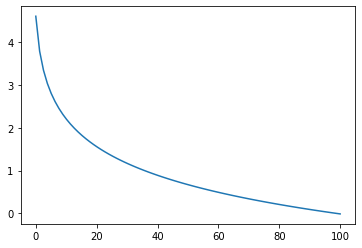

In [79]:
x = np.linspace(0, 100, num = 80)
sns.lineplot(x = x, y = np.log(100 / (x + 1)));###Equation above, have plus 1 so you never have 0 in the denominator

TFs give us the relative frequency terms in the documents. We use the IDFs to then dampen the TFs for terms that appear frequently across documents by virtue of being common terms. This will make it so rarer terms get to exert more influence during the machine learning phase.

Applications of TF-IDF include

- Characterize writing styles
- Comparing authors
- Determining original authors
- Finding plagiarism

Let's now implement this for the tweet data:

### Step 1: Get the term-document matrix

We first break up the words in the text:

In [80]:
clean_texts = tweet_df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

print('Example entry: {}'.format(docs[np.random.choice(ix)]))

Example entry: ['chillin', 'in', 'the', 'hotel', 'room', 'were', 'about', 'to', 'check', 'out', 'the', 'city', 'richmond', 'va', 'then', 'head', 'home', 'gonna', 'b', 'traveling', 'aaaaallll', 'day']


We can now create our corpus, keeping track of its size.

In [81]:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

print('Our tweet-vocabulary has {} distinct words.'.format(len(vocab)))

Our tweet-vocabulary has 64566 distinct words.


Let's now convert everything to a numpy array. We should keep track of how the vocab/term indices map to the matrix so that we can look them up later.

In [82]:
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

vocab_sorter = np.argsort(vocab)

print('Vocab: {}'.format(vocab[:5]))
print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:20]]))

Vocab: ['anthmauro' 'postmemorial' 'allowance' 'blessed' 'uplifter']
Sorted Vocab: ['a' 'aa' 'aaa' 'aaaaa' 'aaaaaa' 'aaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaahmmmmmmmmmm' 'aaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhh' 'aaaaaaaaand' 'aaaaaaaall'
 'aaaaaaaaw' 'aaaaaaah' 'aaaaaagh' 'aaaaaah' 'aaaaaaw' 'aaaaache' 'aaaaah']


We now initialize the **term-document matrix**. This is a matrix where each row $i$ is a document and each column $j$ is a word. The entriy $(i, j)$ of the matrix shows the frequency of the word $j$ in document $i$.

In [83]:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
data = np.empty(num_nonzero, dtype = np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype = np.intc)     # row index
cols = np.empty(num_nonzero, dtype = np.intc)     # column index

We can now populate the term-document matrix: Each row $i$ is a document and each column $j$ is a word. The entriy $(i, j)$ of the matrix shows the frequency of the word $j$ in document $i$.

In [84]:
ix = 0
# go through all documents with their terms
print('Computing, please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter = vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts = True)
    n_vals = len(uniq_indices)  # number of unique terms
    ix_end = ix + n_vals # add count to index

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end

print('Done!')

Computing, please wait!
Done!


Let's look at our sorted vocabulary again.

In [85]:
print('First five terms alphabetically: {}'.format(vocab[vocab_sorter[:5]]))

First five terms alphabetically: ['a' 'aa' 'aaa' 'aaaaa' 'aaaaaa']


As you can see, we probably need to do some trimming, as the word 'aaaaa' probably doesn't occur often enough, and having 151,670 unique words may be too much.  We will address this later on. For now, let's keep the corpus we have. We now initialize a sparse matrix that will store the term-document matirx.

In [86]:
doc_term_mat = coo_matrix((data, (rows, cols)), shape = (num_docs, vocab_size), dtype = np.intc)

doc_term_mat 

<53702x64566 sparse matrix of type '<class 'numpy.int32'>'
	with 658645 stored elements in COOrdinate format>

We can now populate the matrix with the term frequencies. We can see an example of this for the word "python" in the code below.

In [87]:
# let's check to make sure!
vocab_list = list(vocab)
word_of_interest = 'python'
vocab_interesting_ix = list(vocab).index(word_of_interest)
print('vocab index of {} : {}'.format(word_of_interest, vocab_interesting_ix))
# find which tweets contain word
doc_ix_with_word = []
for ix, row in enumerate(tweet_data): # note on this line later
    if word_of_interest in row[1]:
        doc_ix_with_word.append(ix)

print('\n1st document index containing said word: {}'.format(doc_ix_with_word[0]))
print('\nTweet: {}'.format(tweet_data[doc_ix_with_word[0]]))

vocab index of python : 35861

1st document index containing said word: 14592

Tweet: [1, "omg, I just found my old vid of monty python's life of brian. it's brilliant, I just can't get enough stan today"]


We can see that the word "python" appears once in the first document (tweet).

**Note:** The term-document matirx `doc_term_mat` is a sparse matirx. So we can't index it using row and column index. Here we don't really need to do that, but if we did we would first need to convert it into an array. We can use the `toarray` method to do that, but if the matrix is large we can easily run out of memory (that's why we're using a spares matrix in the first place!). So instead we can use the `tocrs` method shown below, which uses compression to avoid the memory problem.

In [88]:
# document - term matrix relevant entry
document_row = doc_ix_with_word[0]
vocab_col = vocab_interesting_ix
mat_entry = doc_term_mat.tocsr()[document_row, vocab_col]

print('\nRow {} and column {} of document-term matrix has entry {}'.format(document_row, vocab_col, mat_entry))


Row 14592 and column 35861 of document-term matrix has entry 1


### Step 2: Trimming the document-term matrix

We saw above that we are including terms like 'aaaaa' and 'aaaa', which probably occur very few times. These terms generally occur with unstructured text fields because we allow users to input whatever they feel like and that includes typos.  But be aware that they can also be artifacts of our cleaning process (unintentionally and intentionally).

Since our document-term matrix is a matrix of counts of words (columns) in each document (rows), we want to remove words that don't occur very frequently across our corpus. The count of how frequent a word is in all of our corpus is just the sum of each column.

In [95]:
word_counts = doc_term_mat.sum(axis = 0)
print(word_counts)

[[1 1 1 ... 1 3 1]]


Let's look at how many words are above a specific cutoff, such as 15:

In [96]:
cutoff = 15
word_count_list = word_counts.tolist()[0]
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 2805


We can now trim our vocabulary and document term matrix.

In [97]:
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

doc_term_mat_trimmed = doc_term_mat.tocsc()[:, col_cutoff_ix]
print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

Shape of document-term matrix before trimming: (53702, 64566)
Shape of document-term matrix after trimming: (53702, 2805)


In [98]:
# Look at first 10 words alphabetically
vocab_trimmed[vocab_sorter_trimmed[0:10]]

array(['a', 'aaron', 'able', 'about', 'absolutely', 'abt', 'ac', 'accent',
       'accept', 'access'], dtype='<U19')

How do we know what cutoff we should use? Let's look at a bar plot words in descending frequency before and after we trimmed it.

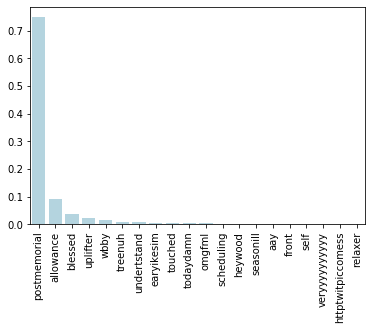

In [99]:
counts = pd.value_counts(word_count_list, normalize = True)[:20]
words = [vocab[x] for x in counts.index][:20]
g = sns.barplot(x = words, y = counts, color = 'lightblue')
g.set_xticklabels(rotation = 90, labels = words);

We can see the bar plot is very skewed. There are too many words that appear few times. Let's check out the trimmed list.

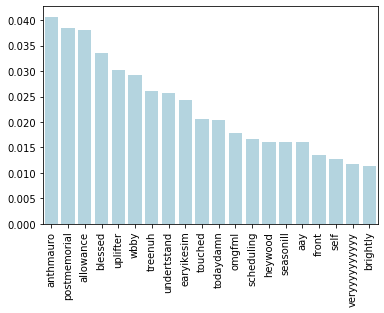

In [100]:
trimmed_word_counts = doc_term_mat_trimmed.sum(axis = 0)
trimmed_word_list = trimmed_word_counts.tolist()[0]

counts = pd.value_counts(trimmed_word_list, normalize = True)[:20]
counts = counts.reset_index(drop = True)
words = [vocab[x] for x in counts.index][:20]
g = sns.barplot(x = words, y = counts, color = 'lightblue')
g.set_xticklabels(rotation = 90, labels = words);

Note that 15 might be a good cutoff because we get a visible drop off and around 6000 features, but these types of **hyperparameters** for the model will probably need tuning. We will learn about tuning such values in future lectures.

### Step 3: Compute IDF

### Computing Term Frequency

Now that we have computed a document-term matrix, how can we understand it? Recall that the simple **Bag of Words model** is just based on **Term Frequency (TF)**. In this case, the weighting of a document for a given term is just the frequency of that term in the document. 

In other cases we will used the **Inverse Document Frequency (IDF)** weighting. IDF weighting accounts for cases where only a few documents contain certain terms. The formula for the IDF weighting can be written as:

$$IDF = log(\frac{Number\ Documents}{Number\ Documents\ with\ Word})$$

The IDF can exhibit a problem however. When there are a few documents with very frequent terms, the weighting is skewed toward those documents.  To solve this problem, we reweight IDF by the overall frequency of the word to create a **term frequency-inverse document frequency (TF-IDF)** matrix. The formula for computing TFIDF is: 

$$TF - IDF = frequency(word) \cdot log(\frac{Number\ Documents}{Number\ Documents\ with\ Word})\ $$

The code in the cell below computes both simple TF and the cumulative of the term frequencies, starting from the most frequent terms to the least.

Scikit-Learn has a built in TF-IDF transformation function that we will use to calculate this and prepare the dataset.

In [101]:
clean_texts = tweet_df['clean_tweet']
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=5856, stop_words='english')#Can change dictionary from 'english' to 'french' if you'd like

# Fit the vectorizer over the dataset
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

In [102]:
# Scikit learn prefers the 'csr' format instead (Compressed Sparse Row format)
tf_idf_tweets

<53702x5856 sparse matrix of type '<class 'numpy.float64'>'
	with 294937 stored elements in Compressed Sparse Row format>

## (Optional) Classification and sentiment analysis

It's hard to talk about feature engineering without moving on to the next step: training a machine learning model. Although we cover this topic on a future lesson, we include here an example in case you can't wait any longer!

Now that we have a prepared TDM of the 160,000 tweets, let's build and evaluate models to classify the sentiment of these tweets. The idea is simple: We use the TF-IDF features for training the model. Since our data also has a column that says if the tweet expresses a positive or negative sentiment, we will train a model to predict the sentiment from the TF-IDF features. So first let's obtain the TF-IDF features once more:

Let's split the featurized data into training and test sets. We will explain why in a future lecture. For training we will use 120,000 tweets to predict the 0,1 sentiment. The remaining 40,000 cases will be used to evaluate the model.

In [103]:
y_targets = np.array([y[0] for y in tweet_data])
y_targets

array([1, 1, 0, ..., 0, 0, 1])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets, y_targets, test_size = 40000, random_state = 42)

Now let's train a logistic classifier on the data:

In [110]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's now evaluate the model.

In [113]:
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [114]:
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.8252809808787038
Test accuracy: 0.7372


Let's also compute the precision, recall and Fscore of the model for positive and negative tweets.

Recall that a positive prediction here means a positive review, and so **precision** is the proportion of correct predictions among all positive predictions and **recall** is the proportion of correct predictions among all true positives. **F1** is the harmonic average of precision and recall.

In [115]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[14515  5487]
 [ 5025 14973]]
             Class 1   -   Class 0
Precision: [0.74283521 0.73181818]
Recall   : [0.72567743 0.74872487]
F1       : [0.73415609 0.740175  ]
Support  : [20002 19998]


##  Summary

NLP applications extend far and wide, so we only stratched the surface here. Many of the modern breakthroughs in deep learning for example have been in NLP. One reason for this is that language data is abundant and the lack of structure in the data presents us with many challenges and learning opportunities. We hope this notebook exposed you to just some examples.

# Assignment (Milestone 2)

We saw how TF-IDF can be used to create features on text data. Let's now look at an example of a special transformation very common in the retail industry: RFM or recency-frequency-monetary transformation. The goal of this assignment is to implement create RFM features for the `retail-churn.csv` data. You will see that having time series data opens us up to many types of features (although how useful they will ultimately be is another question).


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from datetime import timedelta
pd.__version__

'1.1.2'

Let's read the `retail-churn.csv` data we are by now very familiar with.

In [2]:
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../Data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


Run the following steps to feature engineer the data.

1. Convert the `timestamp` column to be of type `datetime`. <span style="color:red" float:right>[1 point]</span>

Reasoning - To be able to switch a column to a datetime type, I will need to use the pd.to_datetime call and pass the necessary column through

In [3]:
churn['timestamp'] = pd.to_datetime(churn['timestamp'])
churn.dtypes

user_id               int64
gender               object
address              object
store_id              int64
trans_id              int64
timestamp    datetime64[ns]
item_id             float64
quantity              int64
dollar                int64
dtype: object

Conclusion - after passing the pd.to_datetime call, I was able to call the churn.dtypes to see that it is now in datetime format

2. Extract the date from `datetime` and store it in a new column called `date`. <span style="color:red" float:right>[1 point]</span>

Reasoning - Will use the dt.strftime call to get the data into a format I can work with for later and also use the pd.to_datetime to store it into a new column called 'date'

In [156]:
churn['date']=churn['timestamp'].dt.strftime("%Y-%m-%d")
churn['date'] = pd.to_datetime(churn['date'])
churn['date'].head()

0   2000-11-01
1   2000-11-01
2   2000-11-01
3   2000-11-01
4   2000-11-01
Name: date, dtype: datetime64[ns]

In [157]:
#Taking a look at the temporal difference
print(churn['date'].min())
print(churn['date'].max())

2000-11-01 00:00:00
2000-12-12 00:00:00


In [158]:
#Making sure that the new column is in datetime format
churn.dtypes

user_id               int64
gender               object
address              object
store_id              int64
trans_id              int64
timestamp    datetime64[ns]
item_id             float64
quantity              int64
dollar                int64
date         datetime64[ns]
dtype: object

Conclusion - By using the strftime command and then the pd.to_datetime, I was able to create 'date' and then convert it into a datetime column. Also found out that my distribution is from January to December of 2000.

Notice that the **granularity** of the data is not daily spend, but rather individual transactions. We can see that because the same user has multiple transactions with the same timestamp. Before we run RFM, we need to **aggregate** the data so we have daily granularity.

3. Aggregate `quantity` and `dollar` to daily data (so that `user_id` and `date` are unique for each row). Call the aggregated data `churn_agg`. You can ignore all the other columns, as they are not needed. <span style="color:red" float:right>[2 point]</span>

Reasoning - To get the user_id and date, I will need to use a groupby, and then aggregate based on quantity (sum) and dollar (sum) to obtain the correct df, churn_agg

In [159]:
#as_index=False - in groupby function
churn_agg = churn.groupby(['user_id', 'date'], as_index=False).agg({'quantity':'sum', 'dollar':'sum'})
churn_agg.head()
churn_agg.dtypes

user_id              int64
date        datetime64[ns]
quantity             int64
dollar               int64
dtype: object

In [160]:
print(churn_agg.quantity.describe())
print(churn_agg.dollar.describe())

count    13328.000000
mean         9.811900
std         18.276495
min          1.000000
25%          3.000000
50%          7.000000
75%         12.000000
max       1200.000000
Name: quantity, dtype: float64
count    13328.000000
mean       891.074205
std       1338.841301
min          9.000000
25%        228.000000
50%        512.000000
75%       1100.000000
max      62688.000000
Name: dollar, dtype: float64


In [161]:
print(churn_agg.columns)
print(churn_agg.dtypes)

Index(['user_id', 'date', 'quantity', 'dollar'], dtype='object')
user_id              int64
date        datetime64[ns]
quantity             int64
dollar               int64
dtype: object


https://towardsdatascience.com/how-to-group-data-by-different-time-intervals-using-python-pandas-eb7134f9b9b0

https://pbpython.com/pandas-grouper-agg.html

Conclusion - By using groupby on user_id and date, I was able to groupby them and then aggregate based on the quantity and dollar that each consumer (user_id) purchased

4. Using the aggregated data, obtain recency, frequency and monetary features for both `dollar` and `quantity`. Use a 7-day moving window for frequency and monetary. Call your new features `last_visit_ndays` (recency) `quantity_roll_sum_7D` (frequency) and `dollar_roll_sum_7D` (monetary). <span style="color:red" float:right>[4 point]</span>

  HINT: In `pandas` recency is a kind of **difference** feature, because it's based on calculating the difference between the current date and a previous date (called a **lag**). We can use the `diff` method to get recency. Frequency and monetary features are called **rolling** features, because it is a type of cumulative sum but over a moving window. We can use the `rolling` function to get frequency and monetary, where the `window` and `on` arguments need to chosen carefully.

Reasoning - I will do this question in parts:
1) To get the last visit in days I will use the diff() call after grouping the user_id based on date

2) I will then use the rolling() function on both the frequency and monetary over 7 days

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://towardsdatascience.com/how-to-group-data-by-different-time-intervals-using-python-pandas-eb7134f9b9b0

In [162]:
churn_agg['last_visit_ndays']=churn_agg.groupby('user_id')['date'].diff()
churn_agg.head()
#last_visit_ndays = churn_agg.groubpy('user_id')['date'].diff()

,user_id,date,quantity,dollar,last_visit_ndays
0,1113,2000-11-12,5,420,NaT
1,1113,2000-11-26,3,558,14 days
2,1113,2000-11-27,6,624,1 days
3,1823,2000-11-02,16,1256,NaT
4,1823,2000-11-06,6,918,4 days


In [163]:
churn_agg.set_index('date', inplace=True)

In [164]:
quantity_roll_sum_7D = churn_agg.groupby('user_id').rolling('7D')['quantity'].sum()
print(quantity_roll_sum_7D.describe())

count    13328.000000
mean        13.941252
std         31.006416
min          1.000000
25%          5.000000
50%          9.000000
75%         17.000000
max       1659.000000
Name: quantity, dtype: float64


In [165]:
dollar_roll_sum_7D = churn_agg.groupby('user_id').rolling('7D')['dollar'].sum()
print(dollar_roll_sum_7D.describe())

count    13328.000000
mean      1257.541792
std       2052.527607
min          9.000000
25%        343.000000
50%        747.000000
75%       1502.250000
max      66974.000000
Name: dollar, dtype: float64


Conclusion - Was able to get all three parts finished and sorted, only thing was when I tried to set the last_visit_ndays as its own series it would not let me, is that an issue with the index???

5. Combine all three features into a single `DataFrame` and call it `churn_roll`. <span style="color:red" float:right>[1 point]</span>

Reasoning - This one I will need to combine the quantity_roll, dollar_roll, and the last visitndays. Based on above, I will need to seperate out the last_visit_n_days and then combine it with the quantity roll and dollar roll

In [166]:
churn_agg.head()

,user_id,quantity,dollar,last_visit_ndays
date,,,,
2000-11-12,1113,5,420,NaT
2000-11-26,1113,3,558,14 days
2000-11-27,1113,6,624,1 days
2000-11-02,1823,16,1256,NaT
2000-11-06,1823,6,918,4 days


In [167]:
print(quantity_roll_sum_7D.head())
print(dollar_roll_sum_7D.head())

user_id  date      
1113     2000-11-12     5.0
         2000-11-26     3.0
         2000-11-27     9.0
1823     2000-11-02    16.0
         2000-11-06    22.0
Name: quantity, dtype: float64
user_id  date      
1113     2000-11-12     420.0
         2000-11-26     558.0
         2000-11-27    1182.0
1823     2000-11-02    1256.0
         2000-11-06    2174.0
Name: dollar, dtype: float64


In [168]:
churn_agg.reset_index(inplace=True)
churn_agg.head()

,date,user_id,quantity,dollar,last_visit_ndays
0,2000-11-12,1113,5,420,NaT
1,2000-11-26,1113,3,558,14 days
2,2000-11-27,1113,6,624,1 days
3,2000-11-02,1823,16,1256,NaT
4,2000-11-06,1823,6,918,4 days


In [169]:
churn_agg.set_index(['user_id', 'date'], inplace=True)
churn_agg.head()

quantity  dollar last_visit_ndays
user_id date                                         
1113    2000-11-12         5     420              NaT
        2000-11-26         3     558          14 days
        2000-11-27         6     624           1 days
1823    2000-11-02        16    1256              NaT
        2000-11-06         6     918           4 days

In [170]:
last_visit_n_days_roll = churn_agg['last_visit_ndays']
last_visit_n_days_roll.head()

user_id  date      
1113     2000-11-12       NaT
         2000-11-26   14 days
         2000-11-27    1 days
1823     2000-11-02       NaT
         2000-11-06    4 days
Name: last_visit_ndays, dtype: timedelta64[ns]

In [171]:
churn_roll = pd.concat([quantity_roll_sum_7D, dollar_roll_sum_7D, last_visit_n_days_roll], axis=1)

churn_roll.rename(columns = {'quantity':'quantity_roll_sum_7D', 'dollar':'dollar_roll_sum_7D', 'recency':'last_visit_n_days_roll'}, inplace=True)
print(churn_roll.head())

                    quantity_roll_sum_7D  dollar_roll_sum_7D last_visit_ndays
user_id date                                                                 
1113    2000-11-12                   5.0               420.0              NaT
        2000-11-26                   3.0               558.0          14 days
        2000-11-27                   9.0              1182.0           1 days
1823    2000-11-02                  16.0              1256.0              NaT
        2000-11-06                  22.0              2174.0           4 days


Conclusion - I was able to merge the three series by manipulating the indexes and working out how to join them

https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python

6. Use `fillna` to replace missing values for recency with a large value like 100 days (whatever makes business sense). HINT: You can use `pd.Timedelta('100 days')` to set the value. <span style="color:red" float:right>[1 point]</span>

Reasoning - I will cal lthe fill.na(pd.Timedelta('100 days') to populate those values

In [172]:
churn_roll['last_visit_ndays'].fillna(pd.Timedelta('100 days'), inplace=True)

user_id  date      
1113     2000-11-12   100 days
         2000-11-26    14 days
         2000-11-27     1 days
1823     2000-11-02   100 days
         2000-11-06     4 days
                        ...   
2163925  2000-12-10   100 days
2163956  2000-12-10   100 days
2164007  2000-12-10   100 days
2164083  2000-12-11   100 days
2164175  2000-12-11   100 days
Name: last_visit_ndays, Length: 13328, dtype: timedelta64[ns]

Conclusion - The call worked by going over all of the Na values and populating them with 100 days

7. To see if things worked, merge the aggregated data `churn_agg` with the RFM features in `churn_roll`. You can use the `merge` method to do this with the right keys specified. <span style="color:red" float:right>[2 point]</span>

Reasoning - Will use the drop call since I believe that I have the last_visit_ndays in both dataframes at this point, after doing that I will merge the two dataframes using the merge()

In [173]:
print(churn_roll.head())
print(churn_agg.head())

                    quantity_roll_sum_7D  dollar_roll_sum_7D last_visit_ndays
user_id date                                                                 
1113    2000-11-12                   5.0               420.0              NaT
        2000-11-26                   3.0               558.0          14 days
        2000-11-27                   9.0              1182.0           1 days
1823    2000-11-02                  16.0              1256.0              NaT
        2000-11-06                  22.0              2174.0           4 days
                    quantity  dollar last_visit_ndays
user_id date                                         
1113    2000-11-12         5     420              NaT
        2000-11-26         3     558          14 days
        2000-11-27         6     624           1 days
1823    2000-11-02        16    1256              NaT
        2000-11-06         6     918           4 days


In [174]:
print(churn_agg.shape)
churn_agg.drop('last_visit_ndays',axis=1, inplace=True)
print(churn_agg.shape)

(13328, 3)
(13328, 2)


In [175]:
print(churn_agg.head())

                    quantity  dollar
user_id date                        
1113    2000-11-12         5     420
        2000-11-26         3     558
        2000-11-27         6     624
1823    2000-11-02        16    1256
        2000-11-06         6     918


In [182]:
merged = pd.merge(churn_agg,churn_roll, right_index = True, 
               left_index = True)
merged['last_visit_ndays'].fillna(pd.Timedelta('100 days'), inplace=True)

In [183]:
merged.head(10)

quantity  dollar  quantity_roll_sum_7D  \
user_id date                                                 
1113    2000-11-12         5     420                   5.0   
        2000-11-26         3     558                   3.0   
        2000-11-27         6     624                   9.0   
1823    2000-11-02        16    1256                  16.0   
        2000-11-06         6     918                  22.0   
4947    2000-12-03        24    1875                  24.0   
        2000-12-10        16    1488                  16.0   
6668    2000-11-11         6     432                   6.0   
        2000-11-25        11     873                  11.0   
        2000-12-03         7     737                   7.0   

                    dollar_roll_sum_7D last_visit_ndays  
user_id date                                             
1113    2000-11-12               420.0         100 days  
        2000-11-26               558.0          14 days  
        2000-11-27              1182.0           1 days  
1823    2000-11-02              1256.0         100 days  
        2000-11-06              2174.0           4 days  
4947    2000-12-03              1875.0         100 days  
        2000-12-10              1488.0           7 days  
6668    2000-11-11               432.0         100 days  
        2000-11-25               873.0          14 days  
        2000-12-03               737.0           8 days

Conclusion - By removing the extra column it decreased the repetitivty of my columns in the dataframe and then allowed for a smooth merge of the two dataframes (churn_roll and churn_agg)

8. Check the features we created to make sure they appear to show the right calculations. You can do this by just checking the first 10 rows of the data. <span style="color:red" float:right>[1 point]</span>

Reasoning - To call the first 10 rows of the merged data I will use the .head(10), will also take a look at the churn_roll and churn_agg .head to make sure they are all on the same page, so to stay

In [177]:
print(merged.head(10))

                    quantity  dollar  quantity_roll_sum_7D  \
user_id date                                                 
1113    2000-11-12         5     420                   5.0   
        2000-11-26         3     558                   3.0   
        2000-11-27         6     624                   9.0   
1823    2000-11-02        16    1256                  16.0   
        2000-11-06         6     918                  22.0   
4947    2000-12-03        24    1875                  24.0   
        2000-12-10        16    1488                  16.0   
6668    2000-11-11         6     432                   6.0   
        2000-11-25        11     873                  11.0   
        2000-12-03         7     737                   7.0   

                    dollar_roll_sum_7D last_visit_ndays  
user_id date                                             
1113    2000-11-12               420.0              NaT  
        2000-11-26               558.0          14 days  
        2000-11-27     

In [178]:
print(churn_agg.head(10))

                    quantity  dollar
user_id date                        
1113    2000-11-12         5     420
        2000-11-26         3     558
        2000-11-27         6     624
1823    2000-11-02        16    1256
        2000-11-06         6     918
4947    2000-12-03        24    1875
        2000-12-10        16    1488
6668    2000-11-11         6     432
        2000-11-25        11     873
        2000-12-03         7     737


In [179]:
print(churn_roll.head(10))

                    quantity_roll_sum_7D  dollar_roll_sum_7D last_visit_ndays
user_id date                                                                 
1113    2000-11-12                   5.0               420.0              NaT
        2000-11-26                   3.0               558.0          14 days
        2000-11-27                   9.0              1182.0           1 days
1823    2000-11-02                  16.0              1256.0              NaT
        2000-11-06                  22.0              2174.0           4 days
4947    2000-12-03                  24.0              1875.0              NaT
        2000-12-10                  16.0              1488.0           7 days
6668    2000-11-11                   6.0               432.0              NaT
        2000-11-25                  11.0               873.0          14 days
        2000-12-03                   7.0               737.0           8 days


Conclusion - The merge seemed to work well and the data is all set and snug in the right frames

One take-away from the above example is that feature engineering can be a complicated topic, and relies to some extent on creativity and domain knowledge, as we saw with time series data and RFM. For this reason, some modern machine learning libraries are working on what is called **automated feature engineering** to see if algorithms can automatically figure out a set of good features to use by the machine learning model.

# End of assignment